# 4개 모델 성능 비교(통합데이터)
```
    Model         Accuracy Flood Recall  ROC AUC
RandomForest        0.980      0.850      0.970
XGBoost             0.964      0.876      0.977
LSTM+CNN            0.587      0.000      0.769
Transformer+SMOTE   0.740      0.910      0.874

최고의 모델은 RANDOMFOREST(통합)
Transformer+SMOTE는 침수 Recall과 AUC에서 강점을 보이며, 실사용 시 "침수 탐지"가 핵심이라면 매우 효과적

해석 요약 테이블
     모델          Accuracy   Recall    ROC AUC    Precision    F1-score
RandomForest        0.980      0.850     0.970       0.960        0.920
XGBoost             0.964      0.876     0.977       0.816        0.845
LSTM+CNN            0.587      0.000     0.769       0.196        0.320
Transformer+SMOTE   0.740      0.910     0.874       0.290        0.440
```

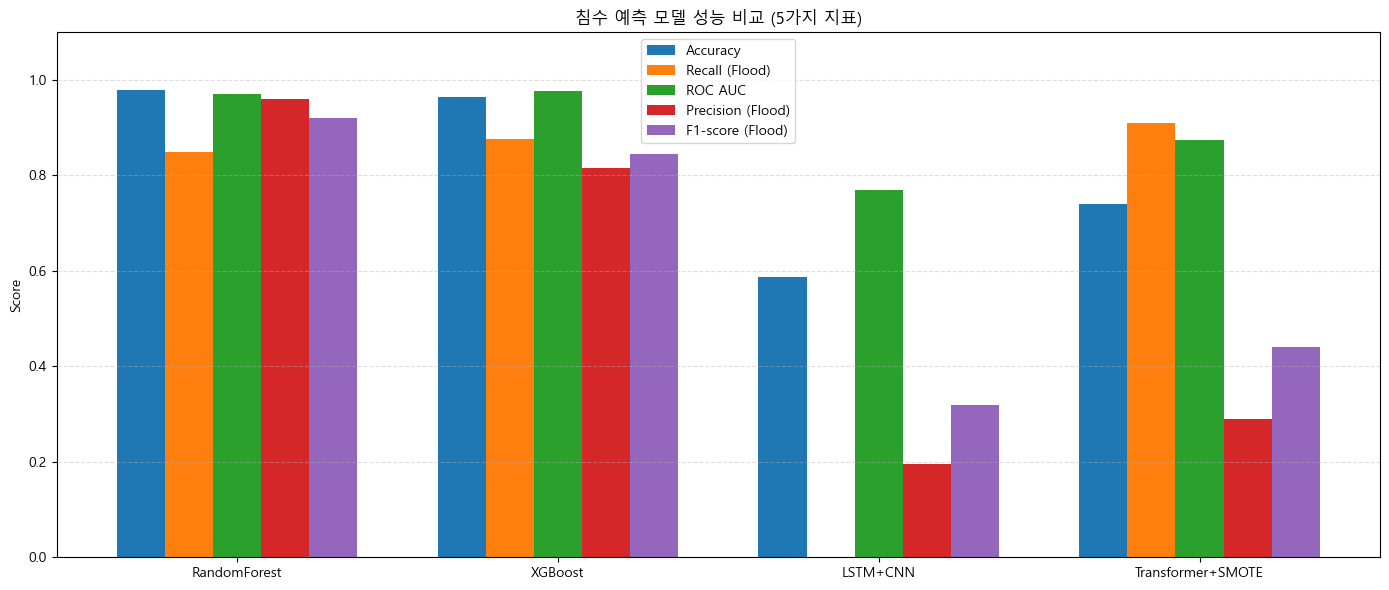

In [11]:
import matplotlib.pyplot as plt

# 모델 이름
models = ["RandomForest", "XGBoost", "LSTM+CNN", "Transformer+SMOTE"]

# 각 성능 지표
accuracy =     [0.980, 0.964, 0.587, 0.740]
recall =       [0.850, 0.876, 0.000, 0.910]   # 침수 Recall
roc_auc =      [0.970, 0.977, 0.769, 0.874]
precision =    [0.960, 0.816, 0.196, 0.290]   # 침수 Precision
f1_score =     [0.920, 0.845, 0.320, 0.440]   # 침수 F1-score

metrics = [accuracy, recall, roc_auc, precision, f1_score]
labels = ["Accuracy", "Recall (Flood)", "ROC AUC", "Precision (Flood)", "F1-score (Flood)"]

x = range(len(models))
bar_width = 0.15

plt.figure(figsize=(14, 6))

for i, metric in enumerate(metrics):
    plt.bar([p + i * bar_width for p in x], metric, width=bar_width, label=labels[i])

plt.xticks([p + 2 * bar_width for p in x], models)
plt.ylim(0, 1.1)
plt.ylabel("Score")
plt.title("침수 예측 모델 성능 비교 (5가지 지표)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

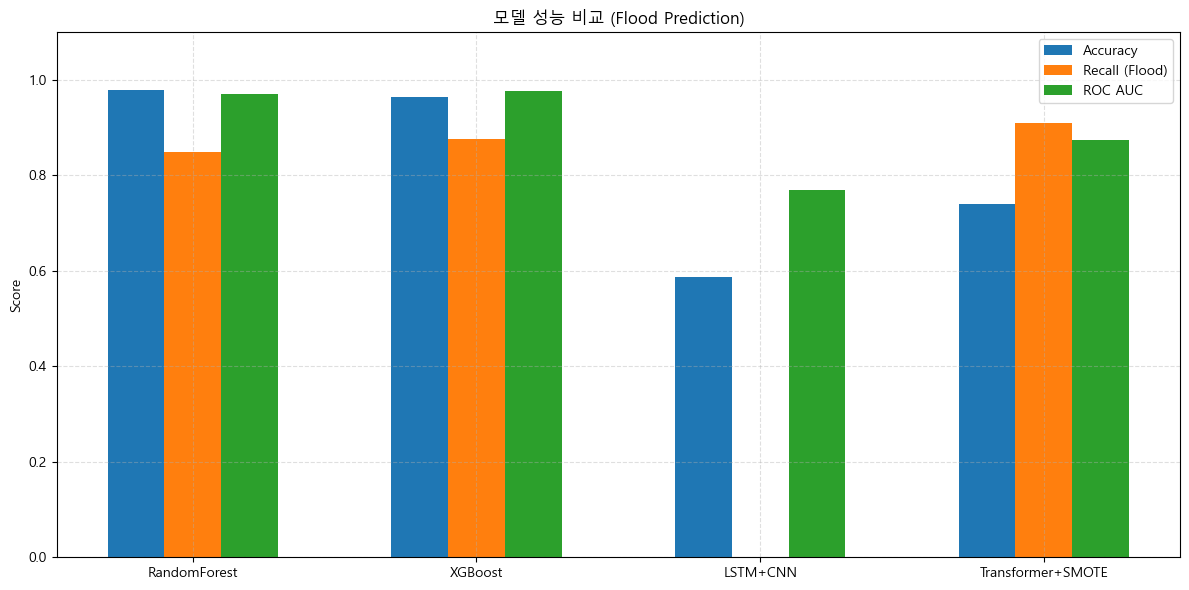

In [10]:
import matplotlib.pyplot as plt

# 모델 이름
models = ["RandomForest", "XGBoost", "LSTM+CNN", "Transformer+SMOTE"]

# 각 모델의 성능 지표
accuracy =     [0.980,     0.964,      0.587,         0.740]
recall_flood = [0.850,     0.876,      0.000,         0.910]  # 침수 클래스 recall
roc_auc =      [0.970,     0.977,      0.769,         0.874]

x = range(len(models))

plt.figure(figsize=(12, 6))

plt.bar(x, accuracy, width=0.2, label='Accuracy', align='center')
plt.bar([i + 0.2 for i in x], recall_flood, width=0.2, label='Recall (Flood)', align='center')
plt.bar([i + 0.4 for i in x], roc_auc, width=0.2, label='ROC AUC', align='center')

plt.xticks([i + 0.2 for i in x], models)
plt.ylim(0, 1.1)
plt.title("모델 성능 비교 (Flood Prediction)")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

# 한글설정, 워닝제거

In [1]:
# 한글설정
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows용 한글 폰트
plt.rcParams['axes.unicode_minus'] = False     # 마이너스(-) 깨짐 방지

#워닝 제거
import warnings
warnings.filterwarnings('ignore')

# api key 활용 및 데이터 수집

In [2]:
import os
from dotenv import load_dotenv
OPENWEATHER_API_KEY = load_dotenv('.env')
OPENWEATHER_API_KEY = os.getenv('OPENWEATHER_API_KEY')
# print(os.getenv('OPENWEATHER_API_KEY'))

# 데이터 전처리

In [4]:
import pandas as pd

# 1. 데이터 불러오기
df = pd.read_csv("asos_seoul_daily_enriched.csv")

# 2. 날짜형 변환
df['tm'] = pd.to_datetime(df['tm'])

# 3. 파생 변수 추가
df['month'] = df['tm'].dt.month
df['day'] = df['tm'].dt.day
df['weekday'] = df['tm'].dt.weekday
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

# 4. 강수량 기반 파생 변수
df['is_rainy'] = df['sumRn'].apply(lambda x: 1 if x >= 30 else 0)  # 30mm 이상이면 침수 위험
df['rain_hours'] = df['sumRn'].apply(lambda x: round(x / 3))  # 대략 시간 수 추정
df['max_hourly_rn'] = df['sumRn'].apply(lambda x: x if x <= 50 else 50)  # capped

# 5. 저장 (선택)
df.to_csv("asos_seoul_daily_enriched.csv", index=False)
print("파생 변수 추가 완료 및 저장됨.")


파생 변수 추가 완료 및 저장됨.


```
컬럼 구성
기본 ASOS 일별 데이터

avgTa, minTa, maxTa : 일평균, 최저, 최고 기온

sumRn : 하루 누적 강수량 (mm)

avgWs, avgRhm, avgTs, avgTd, avgPs : 바람, 습도, 지면온도, 이슬점, 기압 등

tm : 날짜

flood_risk : 침수 위험 (0/1)

추가된 파생 변수 (시간자료 기반 집계)

rn_sum, rn_max, rn_mean : 시간별 강수량 총합, 최고, 평균

ws_max, ws_mean : 풍속 최고/평균

ta_mean, hm_mean : 온도/습도 평균
```

# XGBoost

Confusion Matrix:
 [[622   3]
 [ 12  66]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       625
           1       0.96      0.85      0.90        78

    accuracy                           0.98       703
   macro avg       0.97      0.92      0.94       703
weighted avg       0.98      0.98      0.98       703


ROC AUC Score: 0.9813128205128205


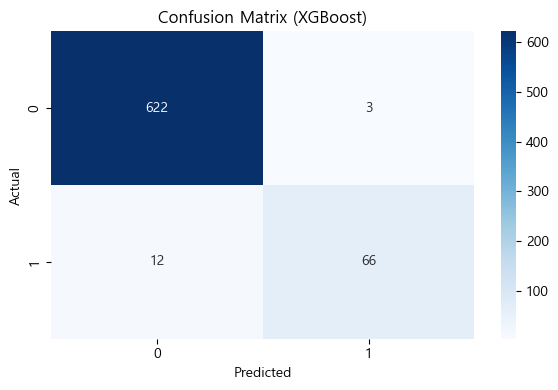

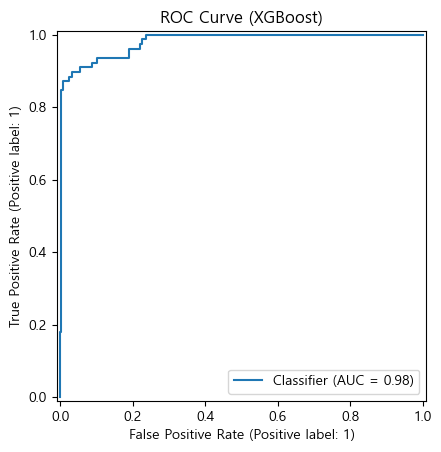

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import joblib
import xgboost as xgb

# 1. 데이터 불러오기
df = pd.read_csv("asos_seoul_daily_enriched.csv")

# 2. 특성과 타겟 정의
features = ['avgTa', 'minTa', 'maxTa', 'sumRn', 'avgWs', 'avgRhm', 'avgTs', 'avgTd', 'avgPs',
            'month', 'day', 'weekday', 'is_weekend', 'is_rainy', 'rain_hours', 'max_hourly_rn']
target = 'flood_risk'

X = df[features]
y = df[target]

# 3. 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# 5. 모델 학습
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train, y_train)

# 6. 평가
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))

# 7. 모델 및 스케일러 저장
joblib.dump(model, "xgb_model_daily.pkl")
joblib.dump(scaler, "xgb_scaler_daily.pkl")

# 8. Confusion Matrix 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (XGBoost)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("xgb_confusion_matrix_daily.png")
plt.show()

# 9. ROC Curve 시각화
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve (XGBoost)")
plt.savefig("xgb_roc_curve_daily.png")
plt.show()

# Precision-Recall Curve 시각화

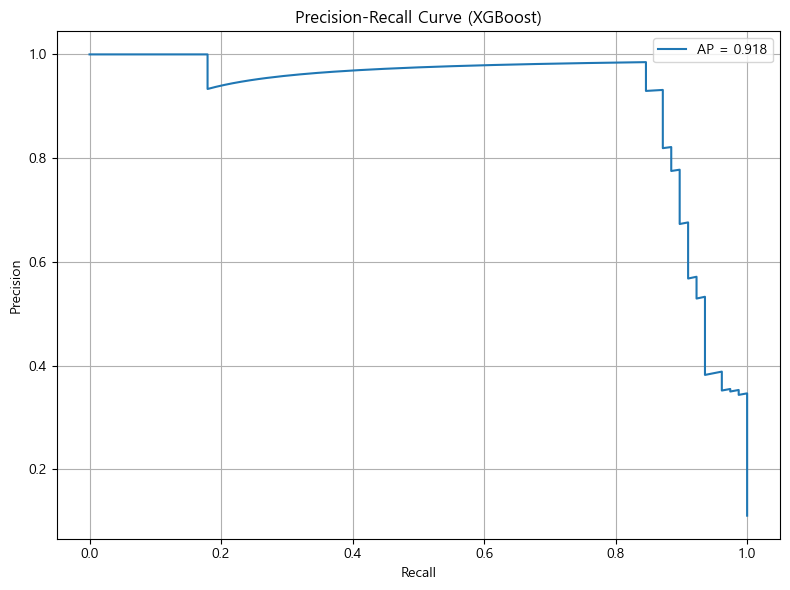

In [6]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# 예측 확률 계산 (양성 클래스)
y_proba = model.predict_proba(X_test)[:, 1]

# Precision-Recall 계산
precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

# 시각화
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AP = {avg_precision:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (XGBoost)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("xgboost_precision_recall_curve.png")
plt.show()

# Feature Importance 시각화 (XGBoost 내장 기능 활용)

<Figure size 1000x600 with 0 Axes>

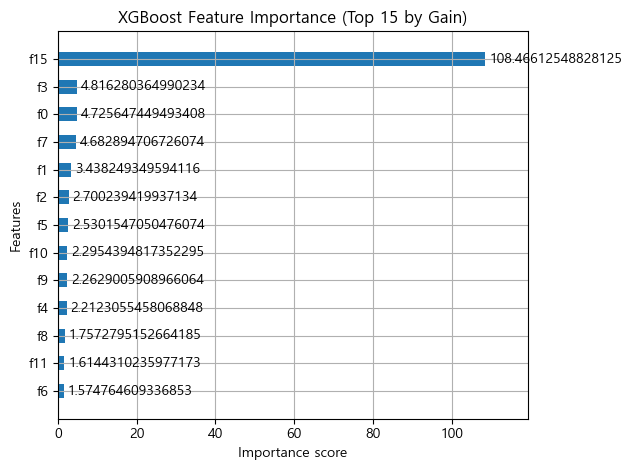

In [7]:
import xgboost as xgb

# 모델이 xgboost.XGBClassifier인 경우, feature importance 그리기
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, importance_type='gain', max_num_features=15, height=0.5)
plt.title('XGBoost Feature Importance (Top 15 by Gain)')
plt.tight_layout()
plt.savefig("xgboost_feature_importance.png")
plt.show()


# 성능 요약
```
Precision: 0.96

Recall: 0.85

f1-score: 0.90

ROC AUC Score: 0.981

균형 잡힌 고성능 모델이라고 볼 수 있음.
이전 시간&일별 모델보다 과소적합 없이 침수 탐지율이 매우 높아짐
```